c:\python\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python\lib\site-packages\scipy\stats\stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


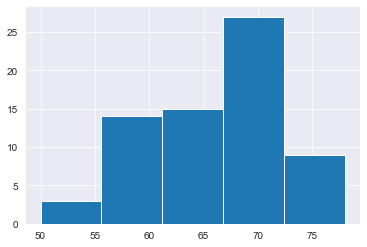

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy.stats
# pip install https://github.com/JamesRitchie/scikit-rvm/archive/master.zip
from skrvm import RVR
from sklearn.svm import SVR
from julearn import run_cross_validation
from julearn.utils import configure_logging
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn import plotting
from nilearn import image
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
sys.path.append("../lib")
from create_splits import stratified_splits

df = pd.read_csv('../data/test_train_MRI.csv', index_col=0)

df_train = df[df['train'] == "T"]
# round to no decimal place
df_train['Age'] = np.around(df_train['Age'].astype(int))
df_train = df_train.reset_index(drop=True)
col = [x for x in df_train.columns if 'H_' in x]
plt.hist(df_train['Age'], bins=5)

c = col

# uncomment for PCA
# [1] creates principal components, 
# [2] calculates cross products of brain scan and principal components,
"""pca = PCA()
pes = pca.fit_transform(df_train[col])

df_pes = pd.DataFrame(pes)
df_pes.columns = ["PC_"+str(i) for i in range(len(pes))]
df_pes['Subject'], df_pes['Age'], df_pes['Age_bins'] = df_train['Subject'], df_train['Age'], df_train['Age_bins']
col1 = [x for x in df_pes.columns if 'PC_' in x]
col2 = []
# [3] considers those principal components that are significantly correlated with age
for i in col1:
    check = scipy.stats.pearsonr(df_pes[i], df_pes['Age'])[1]
    if check < 0.1:
        col2.append(i)
df_train = df_pes
c = col2
"""


c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\python\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


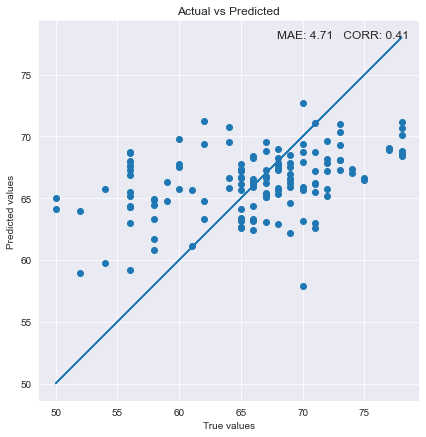

In [17]:
rand_seed = 42
num_bins = 5
rvr = RVR()
models = [rvr, 'svm']
model_names = ['rvr', 'svm']
splits = 5

model_results = []
scores_results = []
res = {}
res['model'] = []
res['iter'] = []
res['pred'] = []
res['ind'] = []
# res = pd.Series(index=df_train.index)
for i, model in enumerate(models):
    cv = StratifiedKFold(n_splits=splits).split(df_train[c],
                                                df_train['Age_bins'])
    cv = list(cv)
    scores, final_model = run_cross_validation(X=c, y='Age',
                                         # preprocess_X='scaler_robust',
                                         problem_type='regression',
                                         data=df_train,
                                         model=model, cv=cv,
                                         return_estimator='all',
                                         seed=rand_seed,
                                         scoring=[
                                            'r2', 'neg_mean_absolute_error'])
    model_results.append(final_model)
    scores_results.append(scores)
    for iter in range(splits):
        pred = scores.estimator[iter].predict(df_train.iloc[cv[iter][1]][c])
        res['pred'].append(pred)
        res['iter'].append(iter)
        res['model'].append(str(model))
        res['ind'].append(cv[iter][1])

df_res = pd.DataFrame(res)
age_pred = {}
age_pred['subj'] = []
age_pred['pred'] = []
age_pred['real'] = []
for i, fold in enumerate(df_res['ind']):
    for ind, sample in enumerate(fold):
        age_pred['real'].append(df_train.iloc[sample]['Age'])
        age_pred['pred'].append(df_res['pred'].iloc[i][ind])
        age_pred['subj'].append(df_train.iloc[sample]['Subject'])

df_ages = pd.DataFrame(age_pred)

y_true = age_pred['real']
y_pred = age_pred['pred']

mae = format(mean_absolute_error(y_true, y_pred), '.2f')
corr = format(np.corrcoef(y_pred, y_true)[1, 0], '.2f')

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set_style("darkgrid")
plt.scatter(y_true, y_pred)
plt.plot(y_true, y_true)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
text = 'MAE: ' + str(mae) + '   CORR: ' + str(corr)
ax.set(xlabel='True values', ylabel='Predicted values')
plt.title('Actual vs Predicted')
plt.text(xmax - 0.01 * xmax, ymax - 0.01 * ymax, text, verticalalignment='top',
         horizontalalignment='right', fontsize=12)
plt.axis('scaled')
plt.show()

In [3]:
print("RESULTS")
print("\nRIDGE VECTOR REGRESSION:\nR2: ", np.round(np.mean(scores_results[0]['test_r2']),2),
      "\nMAE: ", np.abs(np.round(np.mean(scores_results[0]['test_neg_mean_absolute_error']),2)))
print("\nSUPPORT VECTOR MACHINE:\nR2: ", np.round(np.mean(scores_results[1]['test_r2']),2),
      "\nMAE: ", np.abs(np.round(np.mean(scores_results[1]['test_neg_mean_absolute_error']),2)))


RESULTS

RIDGE VECTOR REGRESSION:
R2:  -0.09 
MAE:  5.55

SUPPORT VECTOR MACHINE:
R2:  0.0 
MAE:  5.23


### Plot Relevant Regions

In [ ]:
# permutation importance
rvr.fit(X,y)
rvr_feature_importance = permutation_importance(model_r[0]['rvr'],X,y, scoring="r2")
svm = SVR().fit(X,y)
svr_feature_importance = permutation_importance(svm,X,y, scoring="r2")
fig,ax = plt.subplots(1,2, figsize = (15,5))
ax[0].bar(range(X.shape[1]),rvr_feature_importance.importances_mean)
ax[1].bar(range(X.shape[1]),svr_feature_importance.importances_mean)
plt.show()

In [ ]:
# threshold importance indication for better interpretability
rvr_imp = [x if x>=0.001 or x<-0.001 else 0 for x in rvr_feature_importance.importances_mean]
svr_imp = [x if x>=0.002 else 0 for x in svr_feature_importance.importances_mean]

# labels
rvr_labels = [col[x] if rvr_imp[x]!=0 else "" for x in range(200)]
svr_labels = [col[x] if svr_imp[x]!=0 else "" for x in range(200)]

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
ax[0].bar(range(X.shape[1]),rvr_imp)
ax[0].set_title("RVR")
ax[0].hlines(0,0,200,color='black', linewidth = 0.5)
plt.sca(ax[0])
plt.xticks(range(200),rvr_labels, rotation = 90)
ax[1].bar(range(X.shape[1]),svr_imp)
ax[1].set_title("SVR")
plt.sca(ax[1])
plt.xticks(range(200),svr_labels, rotation = 90)
plt.show()

### Plot Relevant Regions in Glass Brain

In [ ]:
schaefer = fetch_atlas_schaefer_2018(n_rois = 200, yeo_networks = 17)
atlas = image.load_img(schaefer.maps)
atlas_matrix = image.get_data(atlas)

In [ ]:
# create statistical map where each voxel value coresponds to permutation importance
rvr_imp = rvr_feature_importance.importances_mean
atlas_matrix_stat = atlas_matrix.copy()

for x in range(201):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat[atlas_matrix_stat==x] = rvr_imp[x-1]
atlas_rvr = image.new_img_like(atlas, atlas_matrix_stat)


In [ ]:
svr_imp = svr_feature_importance.importances_mean
atlas_matrix_stat_svr = atlas_matrix.copy()

for x in range(201):
    if x == 0: 
        pass
    else:
        atlas_matrix_stat_svr[atlas_matrix_stat_svr==x] = svr_imp[x-1]
atlas_svr = image.new_img_like(atlas, atlas_matrix_stat_svr)

In [ ]:
fix, ax = plt.subplots(1,2, figsize=(15,5))
plotting.plot_stat_map(atlas_rvr, axes = ax[0])
ax[0].set_title("RVR-relevant regions for aging")
plotting.plot_stat_map(atlas_svr, axes = ax[1])
ax[1].set_title("SVR-relevant regions for aging")
plt.show()

### Performance on test set

In [4]:
df_test = df[df['train'] == "F"]
df_test['Age'] = np.around(df_test['Age'].astype(int))
df_test = df_test.reset_index(drop=True)

col = [x for x in df_test.columns if 'H_' in x]

y_test = df_test['Age'].values
# round to no decimal place
y_test = np.around(y_test).astype(int)

c:\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


17 17


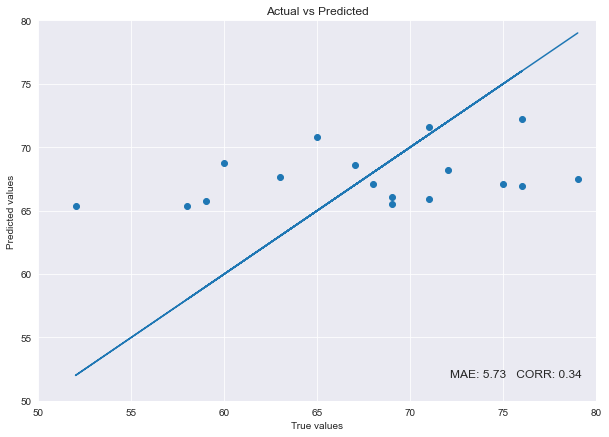

In [5]:
pred = model_results[0]['rvr'].predict(df_test[col])
# uncomment for PCA
"""
pes_test = pca.transform(df_test[col].values)
pred = model_results[0]['rvr'].predict(np.array(pes_test)[:,col2_ind])
"""
mae = format(mean_absolute_error(y_test, pred), '.2f')
corr = format(np.corrcoef(y_test, pred)[1, 0], '.2f')

print(len(pred),len(y_test))
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.scatter(y_test, pred)
plt.plot(y_test,y_test)
plt.xlabel("Ground truth")
plt.ylabel("RVR Prediction")
plt.xlim(50,80)
plt.ylim(50,80)
text = 'MAE: ' + str(mae) + '   CORR: ' + str(corr)
ax.set(xlabel='True values', ylabel='Predicted values')
plt.title('Actual vs Predicted')
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.text(xmax - 0.01 * xmax, ymin + 0.05 * ymin, text, verticalalignment='top',
         horizontalalignment='right', fontsize=12)

plt.show()